Папка charts создана/проверена
=== ДАННЫЕ ДЛЯ conversion.json (22 марта 2023) ===
   platform  visits  registrations    conversion
63  android      77             68 88.3116883117
64      ios      37             32 86.4864864865
65      web     441             30  6.8027210884
=== conversion.json сохранен с данными за 22 марта 2023 ===
=== ads.json сохранен ===


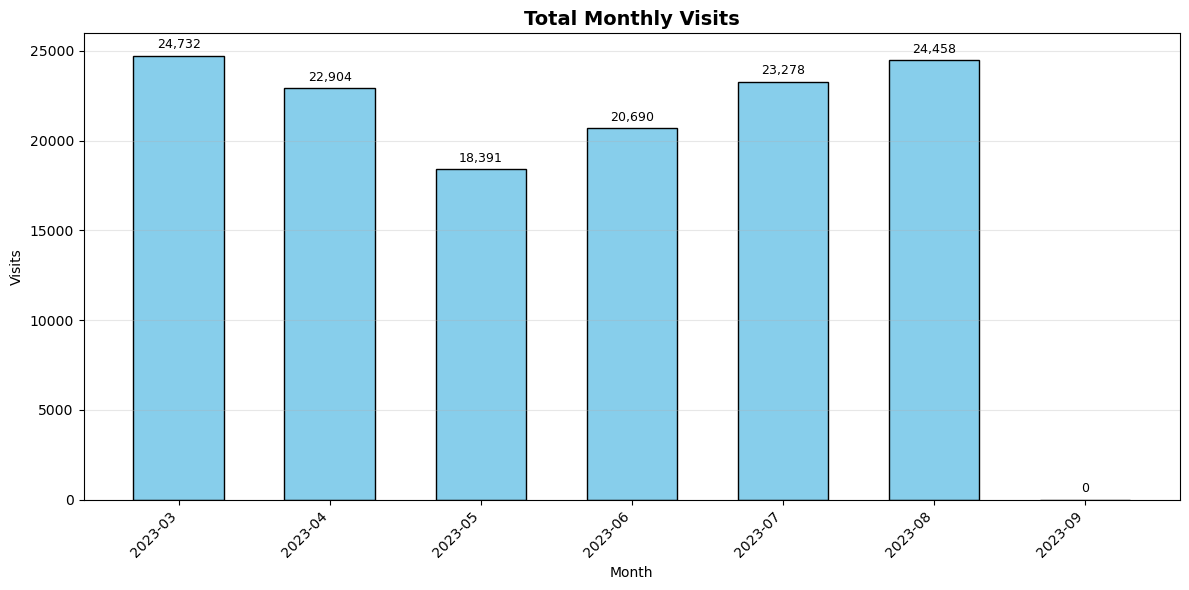

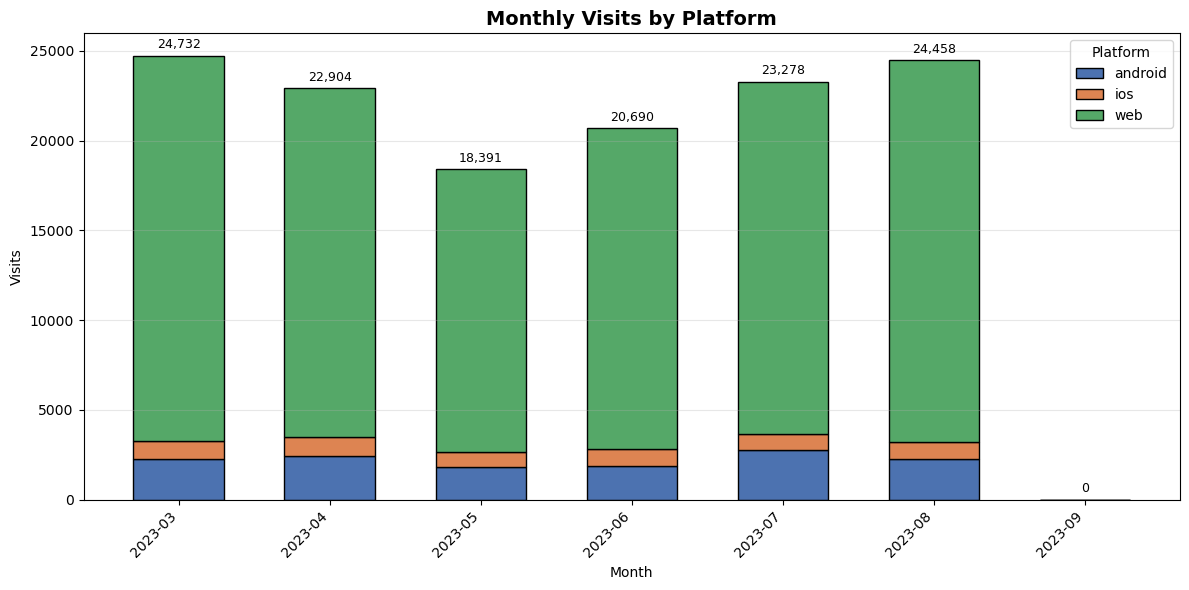

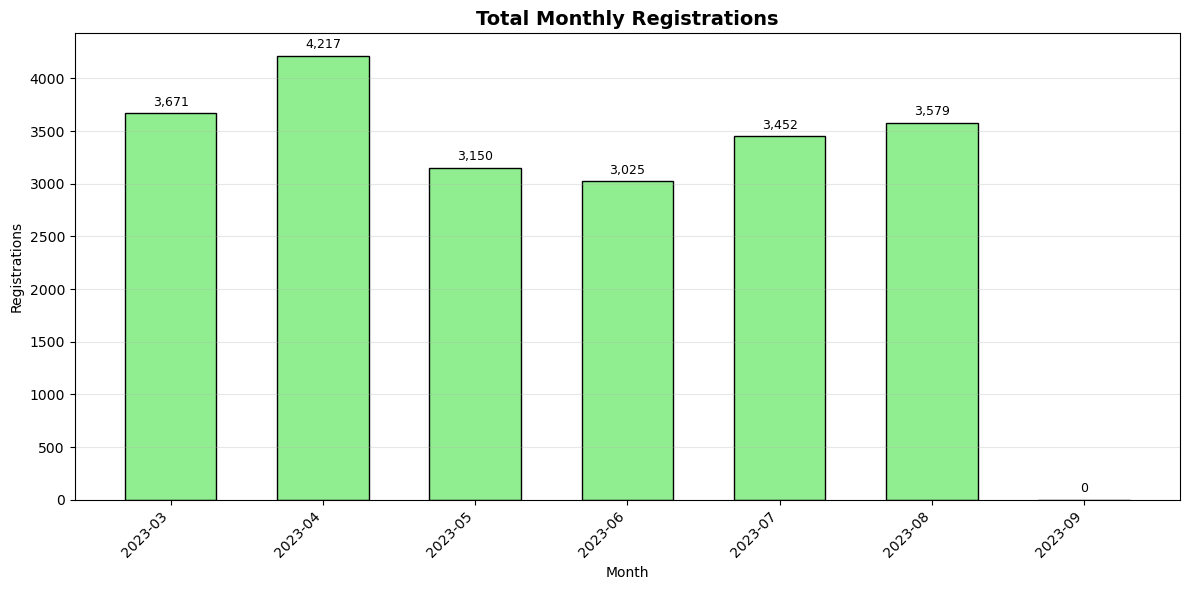

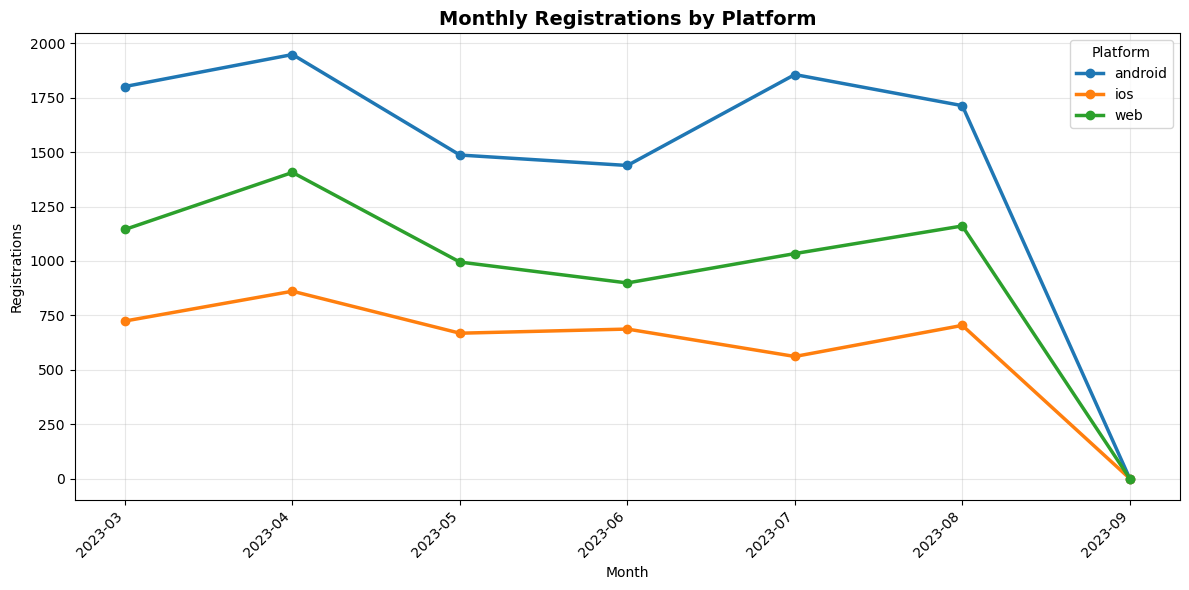

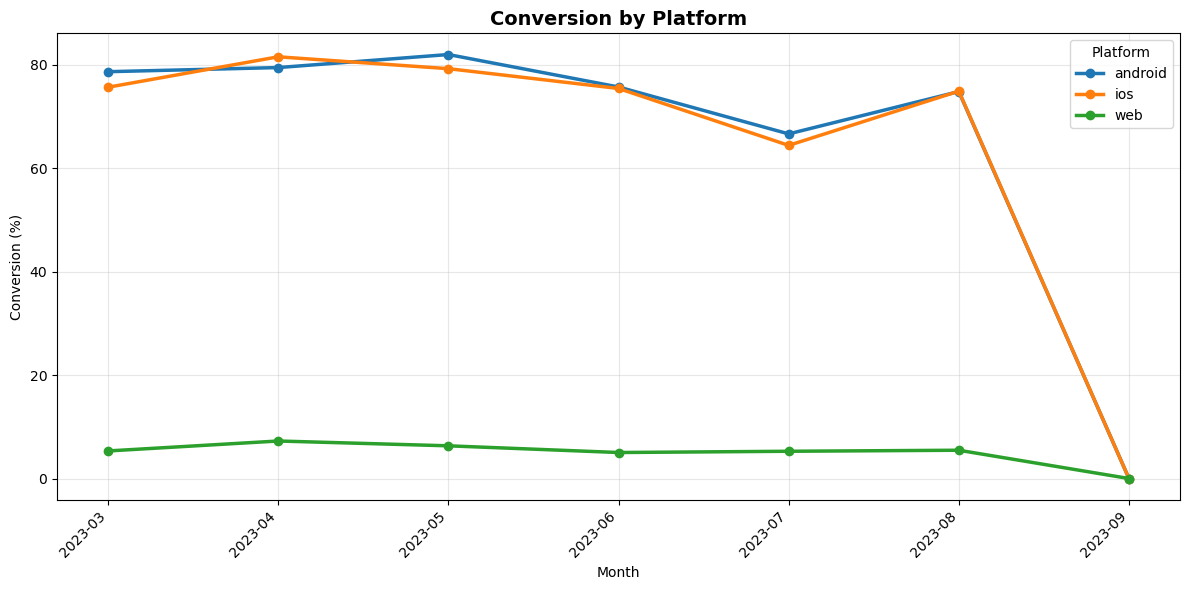

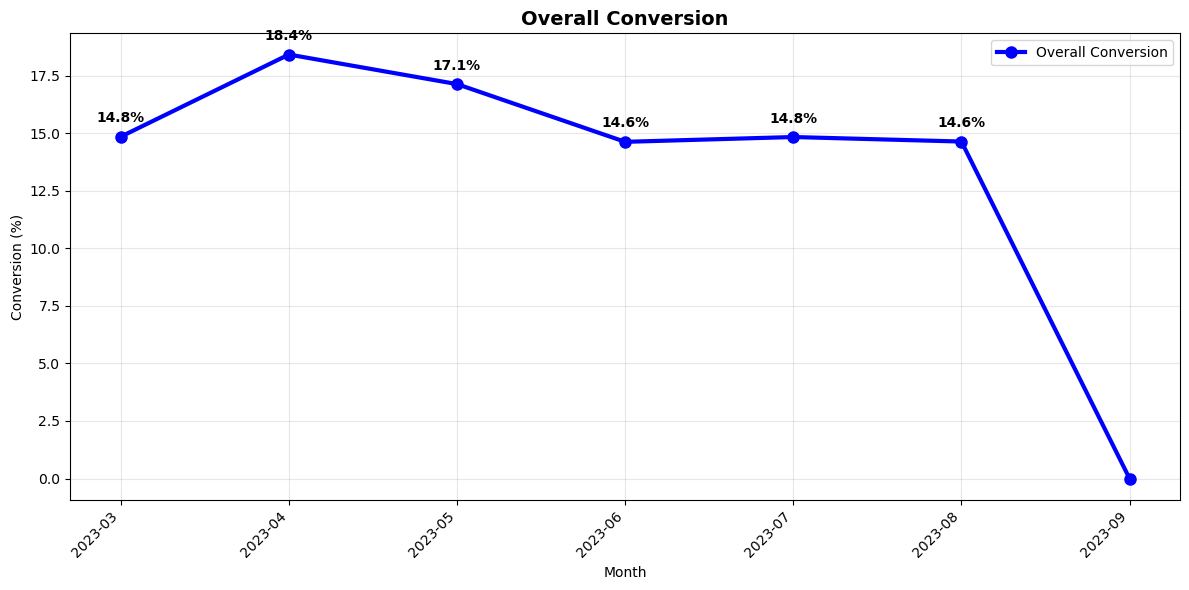

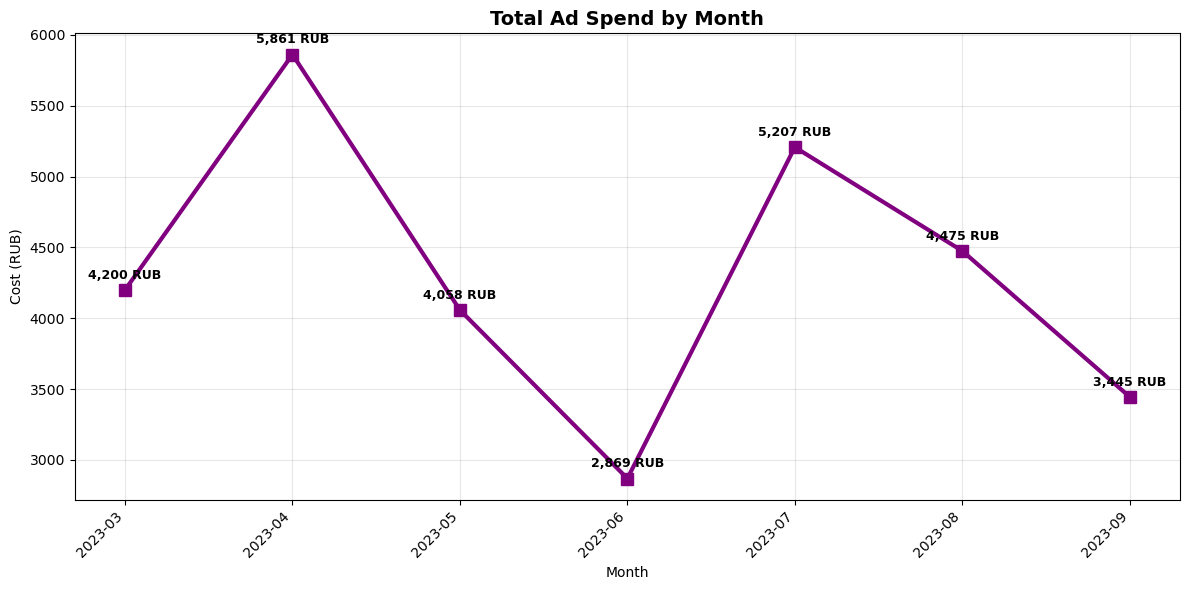

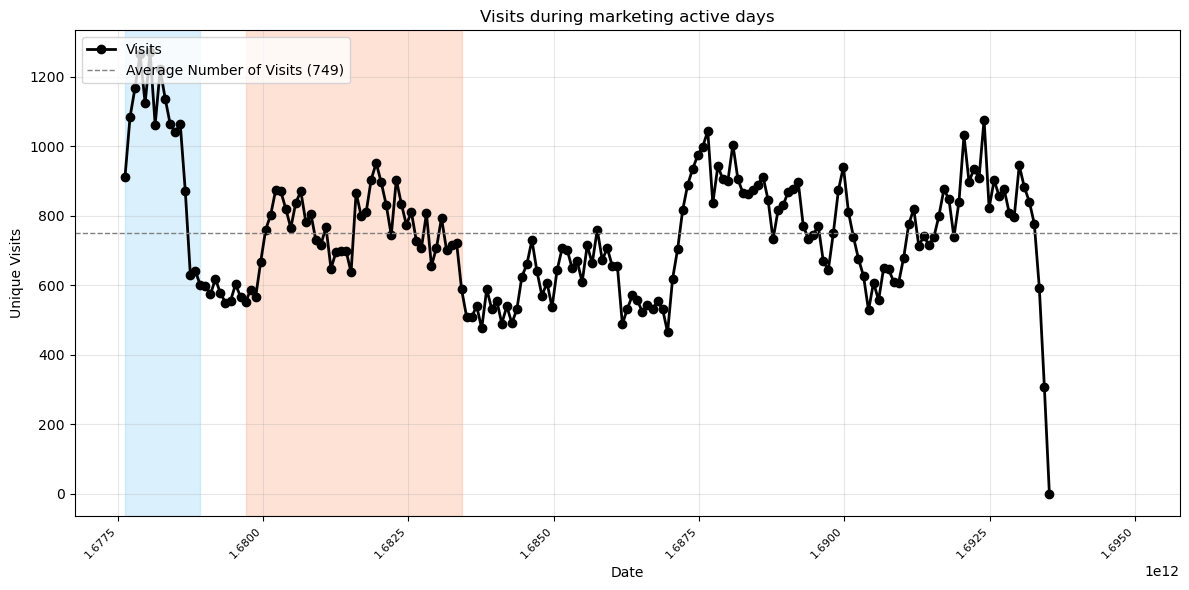

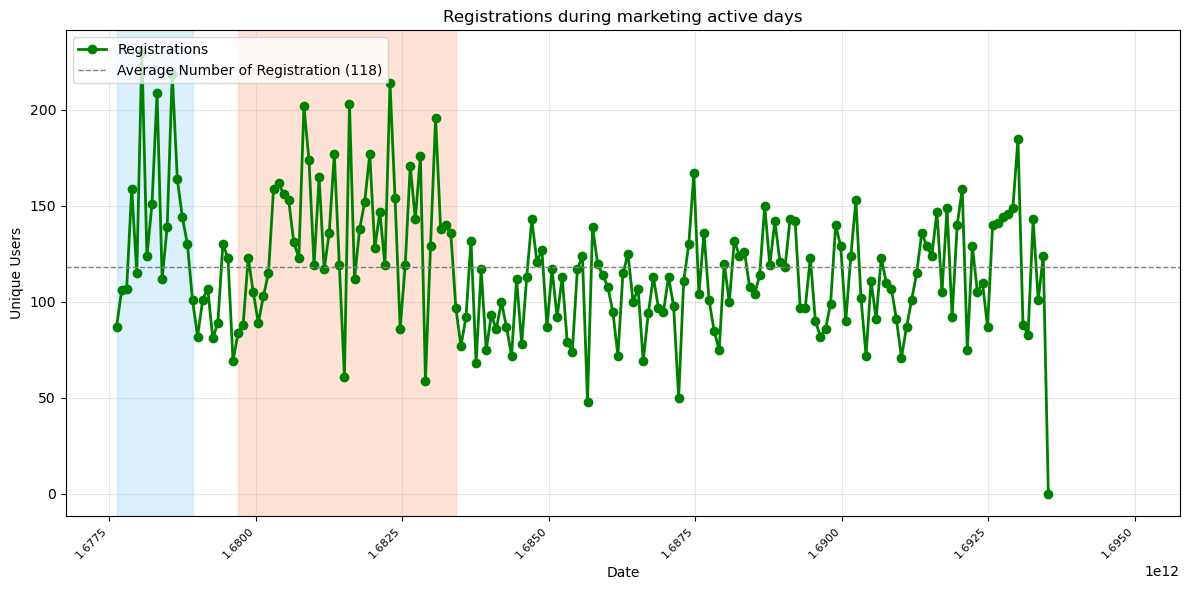

Все 9 графиков успешно созданы!
Диапазон данных: с 2023-03-01 по 2023-09-01
Количество месяцев: 7


In [2]:
# Полный оптимизированный код с 9 графиками размера 12x6
import os
import pandas as pd
import requests
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import json

# Настройки
pd.set_option('display.float_format', '{:.10f}'.format)
plt.style.use('default')

# Создаем папку charts если не существует
os.makedirs('./charts', exist_ok=True)
print("Папка charts создана/проверена")

# Загружаем переменные окружения
load_dotenv()

# Получаем параметры
API_URL = os.getenv('API_URL')
DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')

# Проверка
assert API_URL is not None, "API_URL не задан в .env"
assert DATE_BEGIN is not None, "DATE_BEGIN не задан в .env"
assert DATE_END is not None, "DATE_END не задан в .env"

# === ОПТИМИЗИРОВАННЫЕ ЗАПРОСЫ API ===
def fetch_api_data():
    """Получение данных из API"""
    visits_response = requests.get(
        f"{API_URL}/visits",
        params={'begin': DATE_BEGIN, 'end': DATE_END}
    )
    visits_response.raise_for_status()
    
    regs_response = requests.get(
        f"{API_URL}/registrations", 
        params={'begin': DATE_BEGIN, 'end': DATE_END}
    )
    regs_response.raise_for_status()
    
    visits_df = pd.DataFrame(visits_response.json())
    regs_df = pd.DataFrame(regs_response.json())
    
    # Преобразуем datetime
    visits_df['datetime'] = pd.to_datetime(visits_df['datetime'])
    regs_df['datetime'] = pd.to_datetime(regs_df['datetime'])
    
    return visits_df, regs_df

visits_df_api, registrations_df_api = fetch_api_data()

# === ОПТИМИЗИРОВАННАЯ ПРЕPROCESSING ===
def preprocess_data(visits_df, regs_df):
    """Предобработка данных"""
    # Фильтрация и дедупликация визитов
    visits_filtered = visits_df[visits_df['platform'] != 'bot'].copy()
    visits_deduped = visits_filtered.sort_values('datetime').drop_duplicates(
        subset=['visit_id'], keep='first'
    ).copy()
    
    # Создаём date_group
    visits_deduped['date_group'] = visits_deduped['datetime'].dt.strftime('%Y-%m-%d')
    regs_df['date_group'] = regs_df['datetime'].dt.strftime('%Y-%m-%d')
    
    return visits_deduped, regs_df

visits_deduped, registrations_df_api = preprocess_data(visits_df_api, registrations_df_api)

# === ОПТИМИЗИРОВАННОЕ СОЗДАНИЕ ДАТАФРЕЙМОВ ===
def create_conversion_dataframe(visits_df, regs_df):
    """Создание DataFrame для конверсии"""
    # Группируем данные
    visits_grouped = visits_df.groupby(['date_group', 'platform']).size().reset_index(name='visits')
    regs_grouped = regs_df.groupby(['date_group', 'platform']).size().reset_index(name='registrations')
    
    # Создаём полный календарь
    date_range = pd.date_range(start=DATE_BEGIN, end=DATE_END, freq='D')
    date_strings = date_range.strftime('%Y-%m-%d')
    platforms = ['android', 'ios', 'web']
    calendar = pd.MultiIndex.from_product([date_strings, platforms], 
                                        names=['date_group', 'platform']).to_frame(index=False)
    
    # Объединяем
    conversion_df = calendar.merge(visits_grouped, on=['date_group', 'platform'], how='left') \
                           .merge(regs_grouped, on=['date_group', 'platform'], how='left')
    
    # Заполняем нулями и считаем конверсию
    conversion_df['visits'] = conversion_df['visits'].fillna(0).astype(int)
    conversion_df['registrations'] = conversion_df['registrations'].fillna(0).astype(int)
    conversion_df['conversion'] = conversion_df.apply(
        lambda row: round((row['registrations'] / row['visits']) * 100, 10) if row['visits'] > 0 else 0.0, 
        axis=1
    )
    
    # Сортируем
    conversion_df['platform'] = pd.Categorical(conversion_df['platform'], 
                                             categories=['android', 'ios', 'web'], ordered=True)
    return conversion_df.sort_values(['date_group', 'platform']).reset_index(drop=True)

conversion_df = create_conversion_dataframe(visits_deduped, registrations_df_api)

# === СОХРАНЕНИЕ ФАЙЛОВ ===
def save_json_files(conversion_df):
    """Сохранение JSON файлов"""
    # conversion.json - ТОЛЬКО ДАННЫЕ ЗА 22 МАРТА 2023
    conversion_df_22_march = conversion_df[conversion_df['date_group'] == '2023-03-22'].copy()
    
    print("=== ДАННЫЕ ДЛЯ conversion.json (22 марта 2023) ===")
    print(conversion_df_22_march[['platform', 'visits', 'registrations', 'conversion']])
    
    df_for_json = conversion_df_22_march.copy()
    df_for_json['date_group'] = (pd.to_datetime(df_for_json['date_group']).astype('int64') // 10**6)
    df_for_json.to_json('./conversion.json', orient='columns', double_precision=10)
    print("=== conversion.json сохранен с данными за 22 марта 2023 ===")
    
    # ads.json
    ads_df = pd.read_csv('./ads.csv')
    ads_df['date'] = pd.to_datetime(ads_df['date'])
    ads_df['date_group'] = ads_df['date'].dt.strftime('%Y-%m-%d')
    
    ads_grouped = ads_df.groupby('date_group').agg({'cost': 'sum', 'utm_campaign': 'first'}).reset_index()
    conversion_df_for_ads = conversion_df.copy()
    conversion_df_for_ads['date_group'] = pd.to_datetime(conversion_df_for_ads['date_group']).dt.strftime('%Y-%m-%d')
    metrics_total = conversion_df_for_ads.groupby('date_group')[['visits', 'registrations']].sum().reset_index()
    
    final_df = metrics_total.merge(ads_grouped, on='date_group', how='outer')
    final_df['cost'] = final_df['cost'].fillna(0).astype(int)
    final_df['utm_campaign'] = final_df['utm_campaign'].fillna('none')
    final_df = final_df.sort_values('date_group').reset_index(drop=True)
    final_df['date_group'] = (pd.to_datetime(final_df['date_group']).astype('int64') // 10**6)
    final_df.to_json('./ads.json', orient='columns')
    print("=== ads.json сохранен ===")
    
    return final_df, ads_df

final_df, ads_df = save_json_files(conversion_df)

# === ОПТИМИЗИРОВАННАЯ АГРЕГАЦИЯ ПО МЕСЯЦАМ ===
def create_monthly_data(visits_df, regs_df, ads_df):
    """Создание месячных агрегатов"""
    date_begin_dt = pd.to_datetime(DATE_BEGIN)
    date_end_dt = pd.to_datetime(DATE_END)
    month_range = pd.date_range(start=date_begin_dt.replace(day=1), 
                               end=date_end_dt.replace(day=1), 
                               freq='MS')
    
    # Визиты по месяцам
    visits_monthly = []
    for month_start in month_range:
        month_end = month_start + pd.offsets.MonthEnd(1)
        month_mask = (visits_df['datetime'] >= month_start) & (visits_df['datetime'] <= month_end)
        month_visits = visits_df[month_mask]
        
        for platform in ['android', 'ios', 'web']:
            visits_monthly.append({
                'date_group': month_start,
                'platform': platform,
                'visits': len(month_visits[month_visits['platform'] == platform])
            })
    
    visits_monthly_df = pd.DataFrame(visits_monthly)
    visits_pivot = visits_monthly_df.pivot_table(index='date_group', columns='platform', 
                                               values='visits', fill_value=0).reset_index()
    
    # Регистрации по месяцам
    regs_monthly = []
    for month_start in month_range:
        month_end = month_start + pd.offsets.MonthEnd(1)
        month_mask = (regs_df['datetime'] >= month_start) & (regs_df['datetime'] <= month_end)
        month_regs = regs_df[month_mask]
        
        for platform in ['android', 'ios', 'web']:
            regs_monthly.append({
                'date_group': month_start,
                'platform': platform,
                'registrations': len(month_regs[month_regs['platform'] == platform])
            })
    
    regs_monthly_df = pd.DataFrame(regs_monthly)
    regs_pivot = regs_monthly_df.pivot_table(index='date_group', columns='platform', 
                                           values='registrations', fill_value=0).reset_index()
    
    # Общие метрики по месяцам
    metrics_monthly = []
    for month_start in month_range:
        month_end = month_start + pd.offsets.MonthEnd(1)
        month_str = month_start.strftime('%Y-%m')
        
        month_visits_mask = (visits_df['datetime'] >= month_start) & (visits_df['datetime'] <= month_end)
        month_regs_mask = (regs_df['datetime'] >= month_start) & (regs_df['datetime'] <= month_end)
        month_ads_mask = (ads_df['date'] >= month_start) & (ads_df['date'] <= month_end)
        
        month_visits_total = len(visits_df[month_visits_mask])
        month_regs_total = len(regs_df[month_regs_mask])
        month_ads = ads_df[month_ads_mask]
        month_cost = month_ads['cost'].sum() if not month_ads.empty else 0
        month_campaign = month_ads['utm_campaign'].mode()[0] if not month_ads.empty and len(month_ads['utm_campaign'].mode()) > 0 else 'none'
        
        metrics_monthly.append({
            'date_group': month_start,
            'month_label': month_str,
            'visits': month_visits_total,
            'registrations': month_regs_total,
            'cost': month_cost,
            'utm_campaign': month_campaign
        })
    
    metrics_monthly_df = pd.DataFrame(metrics_monthly)
    
    # Добавляем метки месяцев
    visits_pivot['month_label'] = visits_pivot['date_group'].dt.strftime('%Y-%m')
    regs_pivot['month_label'] = regs_pivot['date_group'].dt.strftime('%Y-%m')
    metrics_monthly_df['overall_conversion'] = (metrics_monthly_df['registrations'] / 
                                              metrics_monthly_df['visits'].replace(0, 1)) * 100
    
    return visits_pivot, regs_pivot, metrics_monthly_df

visits_pivot, regs_pivot, metrics_monthly = create_monthly_data(
    visits_deduped, registrations_df_api, ads_df
)

# === ПОСТРОЕНИЕ 9 ГРАФИКОВ РАЗМЕРА 12x6 ===
def create_plots(visits_pivot, regs_pivot, metrics_monthly, final_df):
    """Создание всех 9 графиков"""
    
    # Настройки стиля для всех графиков
    plt.rcParams['figure.figsize'] = (12, 6)
    colors = {'android': '#4C72B0', 'ios': '#DD8452', 'web': '#55A868'}
    campaign_colors = {
        'advanced_algorithms_series': '#87CEFA',
        'virtual_reality_workshop': '#FFA07A',
        'none': 'none'
    }
    
    def setup_common_chart(title, ylabel, x_labels, rotation=45):
        """Общие настройки для графиков"""
        plt.title(title, fontsize=14, fontweight='bold')
        plt.xlabel('Month')
        plt.ylabel(ylabel)
        plt.xticks(range(len(x_labels)), x_labels, rotation=rotation, ha='right')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
    
    # 1. Total Monthly Visits
    plt.figure()
    x_pos = range(len(metrics_monthly))
    bars = plt.bar(x_pos, metrics_monthly['visits'], color='skyblue', edgecolor='black', width=0.6)
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(metrics_monthly['visits'])*0.01, 
                f'{int(bar.get_height()):,}', ha='center', va='bottom', fontsize=9)
    setup_common_chart('Total Monthly Visits', 'Visits', metrics_monthly['month_label'])
    plt.savefig('./charts/total_visits.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Monthly Visits by Platform
    plt.figure()
    x_pos = range(len(visits_pivot))
    bottom = np.zeros(len(visits_pivot))
    
    for platform in ['android', 'ios', 'web']:
        values = visits_pivot[platform].values
        plt.bar(x_pos, values, bottom=bottom, color=colors[platform], 
                edgecolor='black', label=platform, width=0.6)
        bottom += values
    
    for i, total in enumerate(bottom):
        plt.text(i, total + max(bottom)*0.01, f'{int(total):,}', 
                ha='center', va='bottom', fontsize=9)
    
    setup_common_chart('Monthly Visits by Platform', 'Visits', visits_pivot['month_label'])
    plt.legend(title='Platform')
    plt.savefig('./charts/visits_by_platform.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Total Monthly Registrations
    plt.figure()
    x_pos = range(len(metrics_monthly))
    bars = plt.bar(x_pos, metrics_monthly['registrations'], color='lightgreen', edgecolor='black', width=0.6)
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(metrics_monthly['registrations'])*0.01, 
                f'{int(bar.get_height()):,}', ha='center', va='bottom', fontsize=9)
    setup_common_chart('Total Monthly Registrations', 'Registrations', metrics_monthly['month_label'])
    plt.savefig('./charts/total_registrations.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 4. Monthly Registrations by Platform
    plt.figure()
    x_pos = range(len(regs_pivot))
    for platform in ['android', 'ios', 'web']:
        plt.plot(x_pos, regs_pivot[platform], marker='o', 
                label=platform, linewidth=2.5, markersize=6)
    setup_common_chart('Monthly Registrations by Platform', 'Registrations', regs_pivot['month_label'])
    plt.legend(title='Platform')
    plt.grid(True, alpha=0.3)
    plt.savefig('./charts/registrations_by_platform.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 5. Conversion by Platform
    plt.figure()
    x_pos = range(len(visits_pivot))
    for platform in ['android', 'ios', 'web']:
        visits = visits_pivot[platform].replace(0, 1)
        regs = regs_pivot[platform]
        conversion = (regs / visits * 100).fillna(0)
        plt.plot(x_pos, conversion, marker='o', 
                label=platform, linewidth=2.5, markersize=6)
    setup_common_chart('Conversion by Platform', 'Conversion (%)', visits_pivot['month_label'])
    plt.legend(title='Platform')
    plt.grid(True, alpha=0.3)
    plt.savefig('./charts/conversion_by_platform.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 6. Overall Conversion
    plt.figure()
    x_pos = range(len(metrics_monthly))
    plt.plot(x_pos, metrics_monthly['overall_conversion'],
            marker='o', linestyle='-', linewidth=3, color='blue', 
            markersize=8, label='Overall Conversion')
    
    for i, row in metrics_monthly.iterrows():
        if not pd.isna(row['overall_conversion']) and row['overall_conversion'] > 0:
            plt.text(i, row['overall_conversion'] + 0.5,
                    f"{row['overall_conversion']:.1f}%",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    setup_common_chart('Overall Conversion', 'Conversion (%)', metrics_monthly['month_label'])
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('./charts/overall_conversion.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 7. Total Ad Spend by Month
    plt.figure()
    x_pos = range(len(metrics_monthly))
    plt.plot(x_pos, metrics_monthly['cost'],
            marker='s', linewidth=3, color='purple', markersize=8)
    
    for i, row in metrics_monthly.iterrows():
        plt.text(i, row['cost'] + max(metrics_monthly['cost'])*0.01, 
                f"{int(row['cost']):,} RUB",
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    setup_common_chart('Total Ad Spend by Month', 'Cost (RUB)', metrics_monthly['month_label'])
    plt.grid(True, alpha=0.3)
    plt.savefig('./charts/ad_campaign_costs.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 8. Visits during marketing active days
    plt.figure()
    plt.plot(final_df['date_group'], final_df['visits'], marker='o', linestyle='-', linewidth=2, color='black', label='Visits')
    avg_visits = final_df['visits'].mean()
    plt.axhline(avg_visits, color='gray', linestyle='--', linewidth=1, label=f'Average Number of Visits ({int(avg_visits)})')
    
    current_campaign = None
    start_date = None
    for i, row in final_df.iterrows():
        campaign = row['utm_campaign']
        if campaign != current_campaign:
            if current_campaign and start_date:
                plt.axvspan(start_date, row['date_group'], color=campaign_colors.get(current_campaign, 'none'), alpha=0.3)
            current_campaign = campaign
            start_date = row['date_group']
    if current_campaign and start_date:
        plt.axvspan(start_date, final_df['date_group'].iloc[-1], color=campaign_colors.get(current_campaign, 'none'), alpha=0.3)
    
    plt.title('Visits during marketing active days', fontsize=12)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Unique Visits', fontsize=10)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig('./charts/visits_during_marketing.png', dpi=300)
    plt.show()
    
    # 9. Registrations during marketing active days
    plt.figure()
    plt.plot(final_df['date_group'], final_df['registrations'], marker='o', linestyle='-', linewidth=2, color='green', label='Registrations')
    avg_regs = final_df['registrations'].mean()
    plt.axhline(avg_regs, color='gray', linestyle='--', linewidth=1, label=f'Average Number of Registration ({int(avg_regs)})')
    
    current_campaign = None
    start_date = None
    for i, row in final_df.iterrows():
        campaign = row['utm_campaign']
        if campaign != current_campaign:
            if current_campaign and start_date:
                plt.axvspan(start_date, row['date_group'], color=campaign_colors.get(current_campaign, 'none'), alpha=0.3)
            current_campaign = campaign
            start_date = row['date_group']
    if current_campaign and start_date:
        plt.axvspan(start_date, final_df['date_group'].iloc[-1], color=campaign_colors.get(current_campaign, 'none'), alpha=0.3)
    
    plt.title('Registrations during marketing active days', fontsize=12)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Unique Users', fontsize=10)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig('./charts/registrations_during_marketing.png', dpi=300)
    plt.show()

# Создаем все 9 графиков
create_plots(visits_pivot, regs_pivot, metrics_monthly, final_df)

print("Все 9 графиков успешно созданы!")
print(f"Диапазон данных: с {DATE_BEGIN} по {DATE_END}")
print(f"Количество месяцев: {len(metrics_monthly)}")